# How to run PEEK on an Inference

## MNIST Demo
This tutorial will work for any convolutional neural network initialized through PyTorch.
The MNIST dataset is used as an example to show results. 

### Imports


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.special import entr

### MNIST - Data Loading

In [14]:
# Data preprocessing and loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### Model - Convolutional Neural Network

In [15]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)  # --> returns 7 x 7
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

### Register Model Forward Hooks

These model forward hooks are registered on the convolutional layers only. They allow for passing of the convolutional feature maps to the ```compute_PEEK``` method. 

Here, the hooks have also been set to only activate when model is in evaluate mode.


In [16]:
model = SimpleCNN()

# Initialize feature_maps dictionary to store the outputs (feature maps) of the layers during inference
feature_maps = {}

def hook_fn(m, i, o):
        if not model.training:  # Ensures it only runs in eval mode
            print(f"Forward Hook (Inference Only) - {m.__class__.__name__}: Output Shape {o.shape}")
            feature_maps[m] = o # storing key-value pair in feature_maps dictionary
            # m --> (module) is the key
            # o --> (output) is the value

# Register hook to the model
model.conv1.register_forward_hook(hook_fn)
model.conv2.register_forward_hook(hook_fn)


### Create an Instance of Model

After the forward hooks have been registered, create an instance of the model. Otherwise the hooks will not initialize properly.

In [17]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train Model

In [18]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.1902
Epoch [2/5], Loss: 0.1807
Epoch [3/5], Loss: 0.0022
Epoch [4/5], Loss: 0.0518
Epoch [5/5], Loss: 0.0277


### Set Model to Evaluate Mode

In [19]:
# set model to evaluate
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Run Inference on Test Image and Collect Feature Maps

```save_feature_maps``` function saves feature maps of test image in specified path. returns feature map path as a string.

In [20]:
# function

def save_feature_maps(model, feature_maps, sample_image, save_path):
    """
    Returns:
        str: Path where the feature maps were saved.
    """

    # Forward pass to capture feature maps
    with torch.no_grad():
        _ = model(sample_image)

    # Create path if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save feature maps
    with open(save_path, "wb") as f:
        pickle.dump({layer: fmap.cpu().numpy() for layer, fmap in feature_maps.items()}, f)

    print(f"Feature maps saved at {save_path}")
    return save_path


Select image to run inference, and select path to save feature maps

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Select a test image to run inference
sample_image, _ = test_dataset[0]  # (first image from test dataset)
sample_image = sample_image.unsqueeze(0).to(device)  # (adding batch dimension)

# Select path to save feature maps
save_path = "./features/sample_image.pkl"

Call ```save_feature_maps``` function

In [22]:
feature_map_path = save_feature_maps(model, feature_maps, sample_image, save_path)

Forward Hook (Inference Only) - Conv2d: Output Shape torch.Size([1, 16, 28, 28])
Forward Hook (Inference Only) - Conv2d: Output Shape torch.Size([1, 32, 14, 14])
Feature maps saved at ./features/sample_image.pkl


### Compute & Plot PEEK from Saved Feature Maps

```compute_PEEK``` function computes a PEEK map using the saved feature maps

```plot_PEEK``` function plots PEEK maps iteratively for each specified convolutional layer

In [23]:
# functions

# original PEEK function
def compute_PEEK(feature_maps, h, w):
    positivized_maps = feature_maps + np.abs(np.min(feature_maps))  # Make positive
    entropy_map = -np.sum(entr(positivized_maps), axis=-1)  # Compute entropy
    peek_map = cv2.resize(entropy_map, (w, h))  # Resize to match original image size
    return peek_map

# function for plotting PEEK maps
def plot_PEEK(modules, sample_image, feature_map_path):
    feature_map_path = feature_map_path if os.path.exists(feature_map_path) else None
    if feature_map_path is None:
        print(f"Feature map path {feature_map_path} does not exist. Please run save_feature_maps first.")

    # Load original image
    image = sample_image.squeeze().cpu().numpy()
    h, w = image.shape

    # Load feature maps
    with open(feature_map_path, 'rb') as f:
        loaded_feature_maps = pickle.load(f)

    # Plot for each convolutional layer
    fig, axes = plt.subplots(len(modules), 2, figsize=(8, 4 * len(modules)))

    for i, layer in enumerate(modules):
        # Original image
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Input')
        axes[i, 0].axis('off')

        # Compute and plot PEEK map
        # Get feature maps using layer as key
        feature_maps = loaded_feature_maps.get(layer, None)
        if feature_maps is None:
          # Find the key in loaded_feature_maps by comparing layer names
          for k in loaded_feature_maps.keys():
            if k.__class__.__name__ == layer.__class__.__name__ and str(k) == str(layer):
              feature_maps = loaded_feature_maps[k]
              break
          if feature_maps is None:
            raise KeyError(f"Layer {layer} not found in loaded_feature_maps")
        feature_maps = feature_maps[0] # Access the first element
        feature_maps = np.moveaxis(feature_maps, 0, -1)  # Rearrange channels
        peek_map = compute_PEEK(feature_maps, h, w)  # Compute PEEK map

        axes[i, 1].imshow(image, cmap='gray')  # Original image
        axes[i, 1].imshow(peek_map, alpha=0.7, cmap='jet')  # Overlay PEEK
        axes[i, 1].set_title(f'PEEK - {layer}')
        axes[i, 1].axis('off')

    fig.tight_layout()
    plt.show()

Call ```plot_PEEK``` function

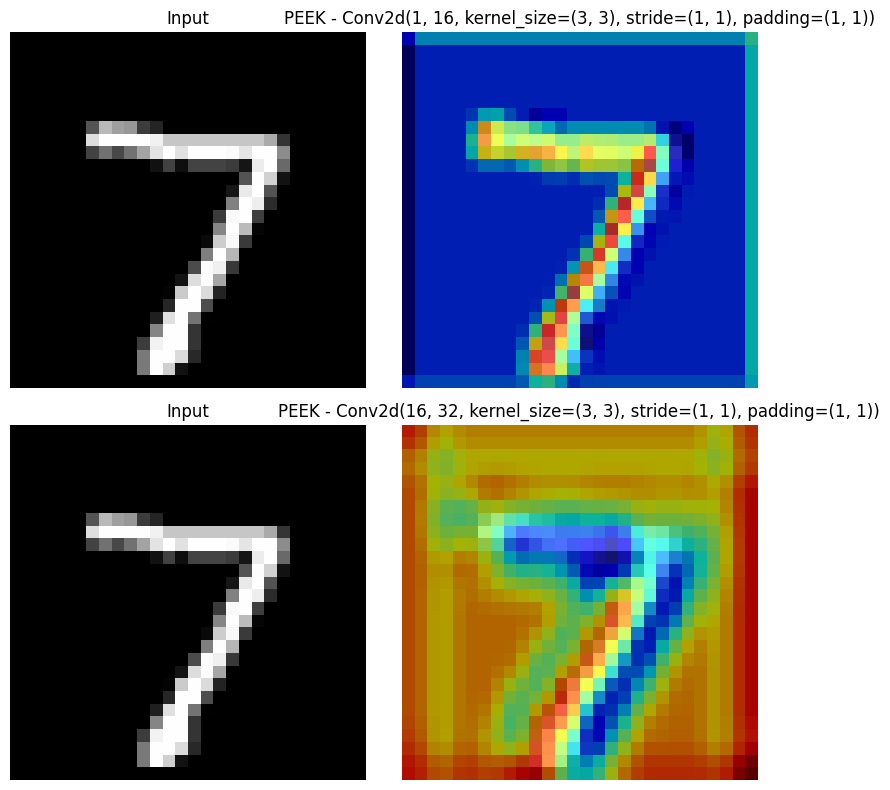

In [24]:
# Run PEEK visualization
plot_PEEK([model.conv1, model.conv2], sample_image, feature_map_path)